In [1]:
import pandas as pd
import numpy as np
import pdb, argparse
import os, pdb, math, itertools
from dotenv import load_dotenv

load_dotenv()
from ultron.factor.genetic.geneticist.operators import *
from lib.lsx001 import fetch_data1, create_factors, create_equal, fetch_chosen_factors,fetch_times

In [2]:
method = 'cicso0'
instruments = 'ims'
period = 5
datasets = ['train', 'val', 'test']

In [3]:
expressions = fetch_chosen_factors(method=method, instruments=instruments)
expressions

[{'formula': "DELTA(4,MMASSI(2,'mid_price_bias_ratio',MSUM(3,'corr_money_ret')))",
  'direction': -1,
  'source': 202509221},
 {'formula': "DELTA(3,DELTA(3,'twap'))", 'direction': -1, 'source': 202509221},
 {'formula': "MMedian(2,MDPO(4,MT3(3,'pct_change')))",
  'direction': -1,
  'source': 202509221},
 {'formula': "DELTA(3,DELTA(3,'mid_price_bias_ratio'))",
  'direction': 1,
  'source': 202509221},
 {'formula': "MT3(2,EMA(2,MT3(2,MCPS(2,MT3(2,EMA(2,DIFF('twap')))))))",
  'direction': 1,
  'source': 202509221},
 {'formula': "MDIFF(4,DIFF(MDEMA(4,MINIMUM('mid_price_bias_ratio','pct_change_set'))))",
  'direction': -1,
  'source': 202509221},
 {'formula': "MMedian(2,MADiff(4,MMedian(2,MADiff(4,MDIFF(3,'pct_change_set')))))",
  'direction': -1,
  'source': 202509225},
 {'formula': "DELTA(3,MADecay(2,DELTA(3,'pct_change_set')))",
  'direction': -1,
  'source': 202509225},
 {'formula': "DELTA(3,DELTA(3,'pct_change_set'))",
  'direction': -1,
  'source': 202509225},
 {'formula': "MADiff(4,MM

In [4]:
total_data = fetch_data1(method=method,
                             instruments=instruments,
                             datasets=datasets,
                             period=period,
                             expressions=expressions)

./records/cicso0/ims/level2/train_data.feather
./records/cicso0/ims/level2/val_data.feather
./records/cicso0/ims/level2/test_data.feather
./records/cicso0/ims/returns/train_returns.feather
./records/cicso0/ims/returns/val_returns.feather
./records/cicso0/ims/returns/test_returns.feather


In [5]:
factors_data = create_factors(total_data=total_data,
                                  expressions=expressions)

DELTA(4,MMASSI(2,'mid_price_bias_ratio',MSUM(3,'corr_money_ret')))
DELTA(3,DELTA(3,'twap'))
MMedian(2,MDPO(4,MT3(3,'pct_change')))
DELTA(3,DELTA(3,'mid_price_bias_ratio'))
MT3(2,EMA(2,MT3(2,MCPS(2,MT3(2,EMA(2,DIFF('twap')))))))
MDIFF(4,DIFF(MDEMA(4,MINIMUM('mid_price_bias_ratio','pct_change_set'))))
MMedian(2,MADiff(4,MMedian(2,MADiff(4,MDIFF(3,'pct_change_set')))))
DELTA(3,MADecay(2,DELTA(3,'pct_change_set')))
DELTA(3,DELTA(3,'pct_change_set'))
MADiff(4,MMedian(2,MADiff(4,'pct_change_set')))
DELTA(3,DELTA(3,'mid_price_bias_ratio'))
MDEMA(2,MCPS(3,MCPS(3,MDEMA(4,'pct_change_close'))))
MDEMA(2,MCPS(3,MDEMA(4,'pct_change_close')))


In [6]:
final_data = create_equal(factors_data=factors_data,
                              total_data=total_data,
                              period=period)
final_data.head()

,trade_time,code,transformed,nxt1_ret_5h
3,2022-07-25 09:35:00,IM,-0.279980,0.000182
8,2022-07-25 09:40:00,IM,1.278323,-0.001167
13,2022-07-25 09:45:00,IM,-2.160799,-0.004245
18,2022-07-25 09:50:00,IM,1.354279,-0.001011
23,2022-07-25 09:55:00,IM,-3.201481,-0.001643


In [7]:
from lib.cux001 import FactorEvaluate1

In [8]:
time_array = fetch_times(method=method, instruments=instruments)

./records/cicso0/ims/level2/train_data.feather
./records/cicso0/ims/returns/train_returns.feather
./records/cicso0/ims/level2/val_data.feather
./records/cicso0/ims/returns/val_returns.feather
./records/cicso0/ims/level2/test_data.feather
./records/cicso0/ims/returns/test_returns.feather


In [9]:
time_array['test_time'][0]

Timestamp('2024-12-05 10:20:00')

In [20]:
final_data1 = final_data.set_index('trade_time').loc[time_array['test_time'][0]:time_array['test_time'][1]].reset_index().dropna()
final_data1.head()

,trade_time,code,transformed,nxt1_ret_5h
0,2024-12-05 10:20:00,IM,-1.873200,-0.001860
1,2024-12-05 10:25:00,IM,1.313258,-0.000206
2,2024-12-05 10:30:00,IM,0.356965,0.003050
3,2024-12-05 10:35:00,IM,0.373695,0.004669
4,2024-12-05 10:40:00,IM,-1.995646,0.000327


In [21]:
evaluate1 = FactorEvaluate1(factor_data=final_data1,
                                factor_name='transformed',
                                ret_name='nxt1_ret_{0}h'.format(period),
                                roll_win=240,
                                fee=0.000,
                                scale_method='roll_zscore',
                                expression='weight')

In [22]:
stats_dt = evaluate1.run()

In [23]:
stats_dt

{'total_ret': 0.06635274777643163,
 'avg_ret': 2.3412785178962926e-05,
 'max_dd': -0.019630260177751158,
 'calmar': 3.3801257433987306,
 'sharpe1': 0.03235041816697762,
 'sharpe2': 3.468929965120835,
 'turnover': 0.3582764628444461,
 'win_rate': 0.46235489220563847,
 'profit_ratio': 1.141041387126392,
 'ic_mean': 0.03903918700052482,
 'ic_std': 0.0745727163055241,
 'ic_ir': 0.5235049617956979,
 'factor_autocorr': -0.1300786525788667,
 'ret_autocorr': -0.037199780961824996}

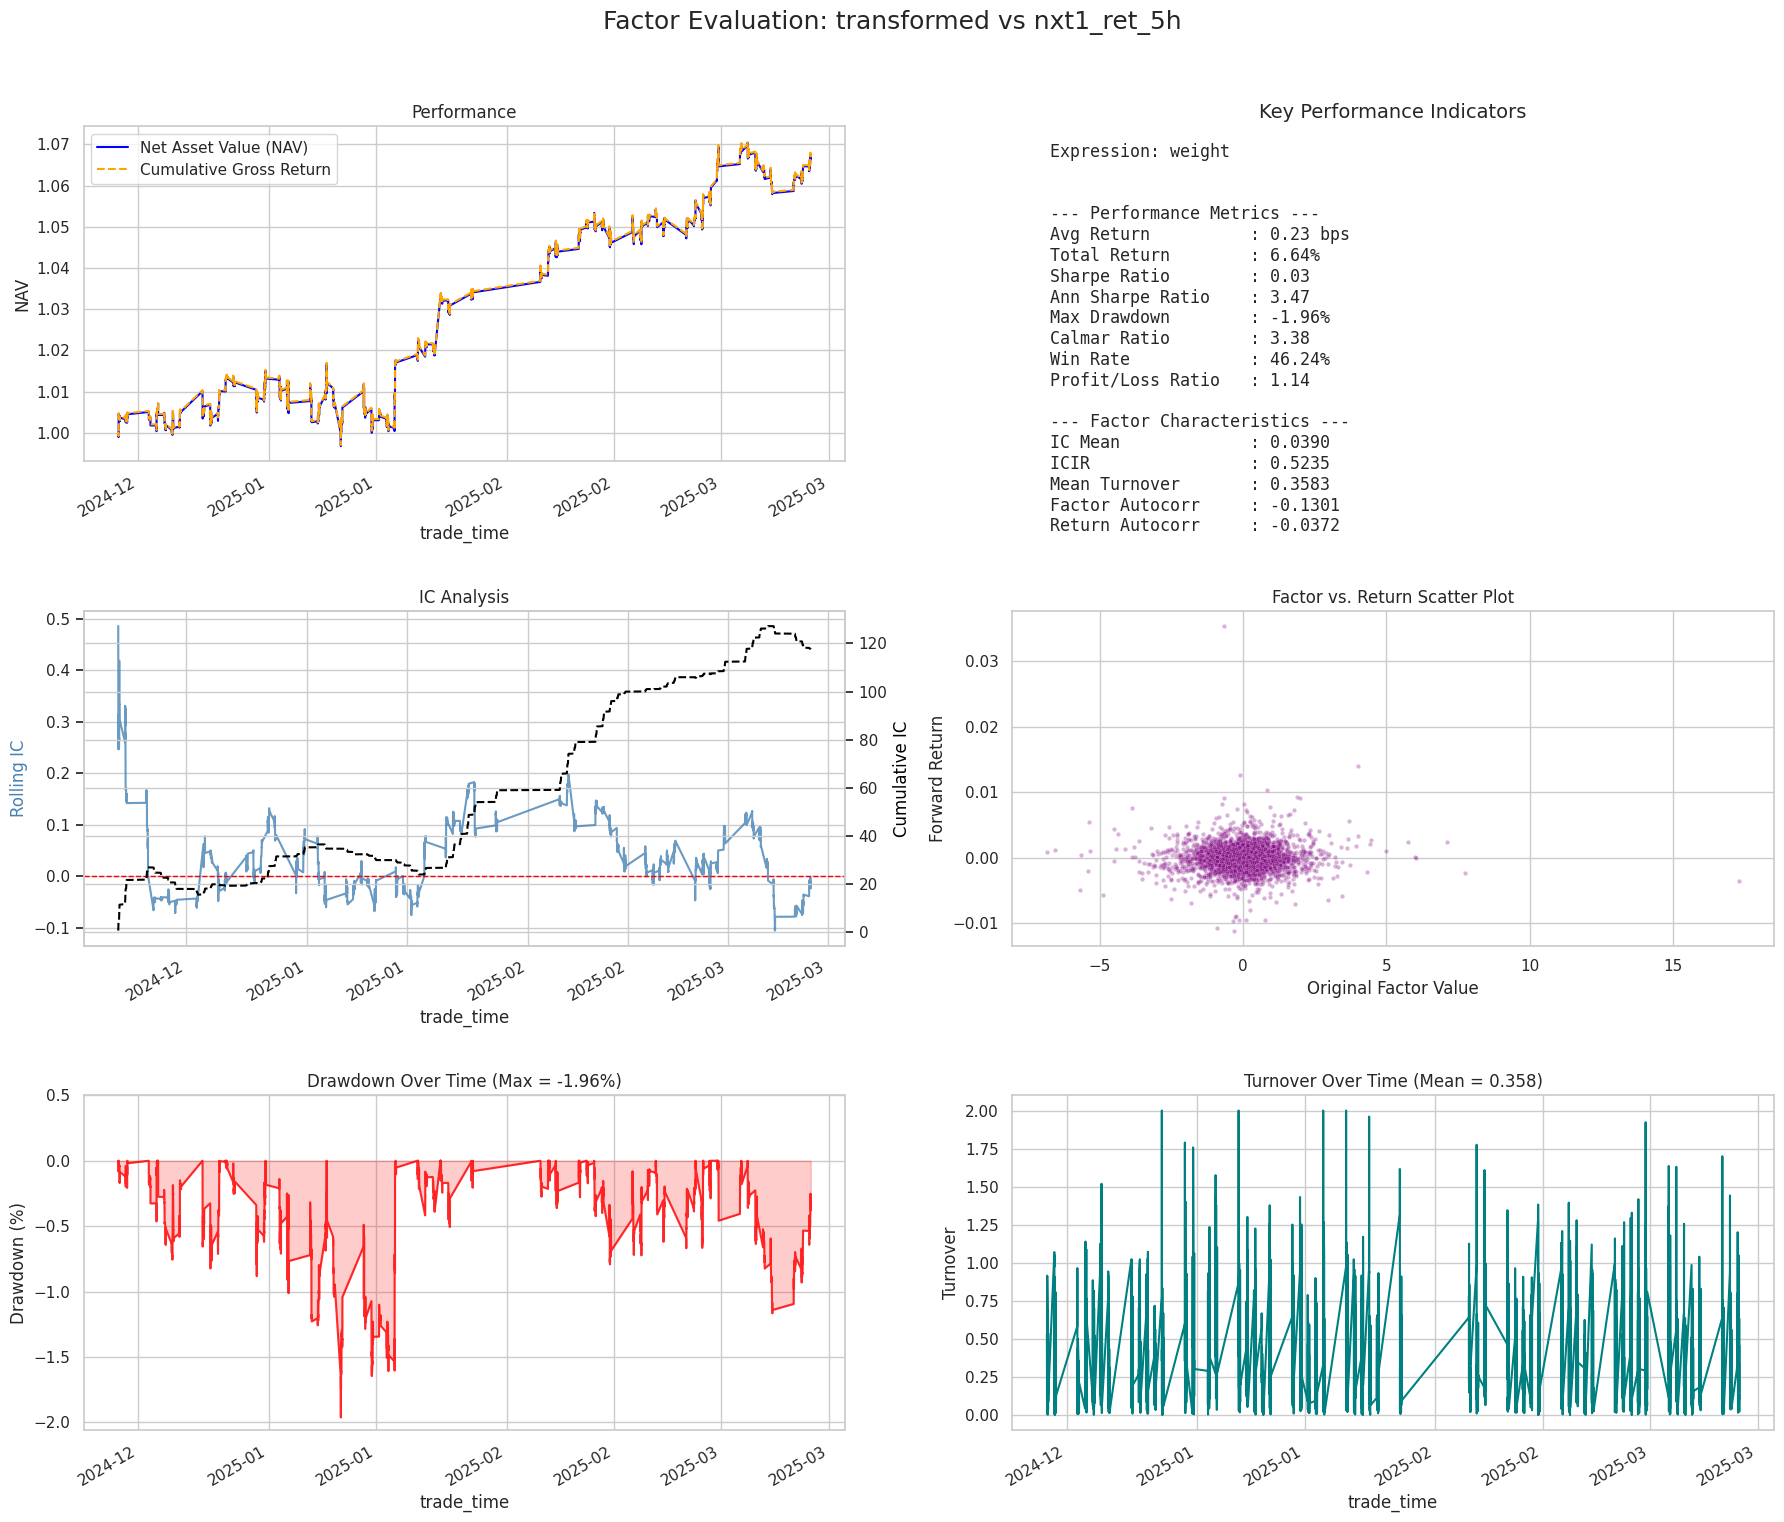

In [24]:
evaluate1.plot_results()